In [23]:
import json
import pandas as pd


# Replace with your actual file path
file_path = "./distilbert_finetuned_emotion_classification/checkpoint-800/trainer_state.json"

# Open and load the JSON file
with open(file_path, "r") as f:
    data = json.load(f)

# Optional: check what’s inside
print(data.keys())           # show top-level keys
print(data["global_step"])   # example: show training step



df = pd.DataFrame(data["log_history"])
df.head()

dict_keys(['best_global_step', 'best_metric', 'best_model_checkpoint', 'epoch', 'eval_steps', 'global_step', 'is_hyper_param_search', 'is_local_process_zero', 'is_world_process_zero', 'log_history', 'logging_steps', 'max_steps', 'num_input_tokens_seen', 'num_train_epochs', 'save_steps', 'stateful_callbacks', 'total_flos', 'train_batch_size', 'trial_name', 'trial_params'])
800


,epoch,grad_norm,learning_rate,loss,step,eval_accuracy,eval_f1,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.08,3.193333,0.00001,0.0975,10,NaN,NaN,NaN,NaN,NaN,NaN
1,0.16,5.619690,0.00001,0.1075,20,NaN,NaN,NaN,NaN,NaN,NaN
2,0.24,3.909809,0.00001,0.1165,30,NaN,NaN,NaN,NaN,NaN,NaN
3,0.32,2.576655,0.00001,0.1164,40,NaN,NaN,NaN,NaN,NaN,NaN
4,0.40,1.967936,0.00001,0.0972,50,NaN,NaN,NaN,NaN,NaN,NaN


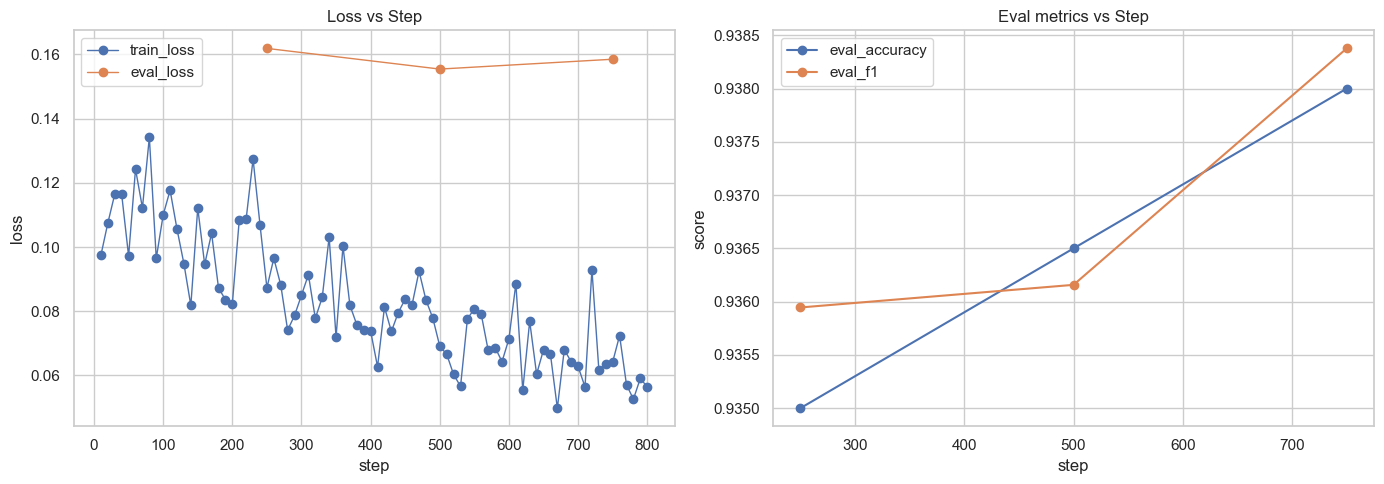

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# logs = pd.DataFrame(trainer.state.log_history)
logs = df
# separate training-loss vs evaluation rows
train_logs = logs[logs["loss"].notnull()].copy()
eval_logs  = logs[logs["eval_loss"].notnull()].copy()

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(train_logs["step"], train_logs["loss"], label="train_loss", marker="o", linewidth=1)
axes[0].plot(eval_logs["step"], eval_logs["eval_loss"], label="eval_loss", marker="o", linewidth=1)
axes[0].set_xlabel("step")
axes[0].set_ylabel("loss")
axes[0].set_title("Loss vs Step")
axes[0].legend()

# Eval metrics plot (accuracy / f1 if present)
if ("eval_accuracy" in eval_logs.columns) or ("eval_f1" in eval_logs.columns):
    if "eval_accuracy" in eval_logs.columns:
        axes[1].plot(eval_logs["step"], eval_logs["eval_accuracy"], label="eval_accuracy", marker="o")
    if "eval_f1" in eval_logs.columns:
        axes[1].plot(eval_logs["step"], eval_logs["eval_f1"], label="eval_f1", marker="o")
    axes[1].set_xlabel("step")
    axes[1].set_ylabel("score")
    axes[1].set_title("Eval metrics vs Step")
    axes[1].legend()
else:
    axes[1].axis("off")

plt.tight_layout()
plt.show()


In [25]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModel
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

In [26]:
emotion = load_dataset('emotion')
emotion.set_format(type='pandas')

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 7310e4a0-99f8-4e1e-a66a-b117e17aa913)')' thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/cab853a1dbdf4c42c2b3ef2173804746df8825fe/dataset_infos.json
Retrying in 1s [Retry 1/5].
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ade93fe8-199e-4264-a282-892544da3430)')' thrown while requesting HEAD https://huggingface.co/datasets/emotion/resolve/cab853a1dbdf4c42c2b3ef2173804746df8825fe/dataset_infos.json
Retrying in 2s [Retry 2/5].


In [27]:
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [28]:
classes = emotion['train'].features['label'].names
classes


df['label_name'] = df['label'].apply(lambda x: classes[x])

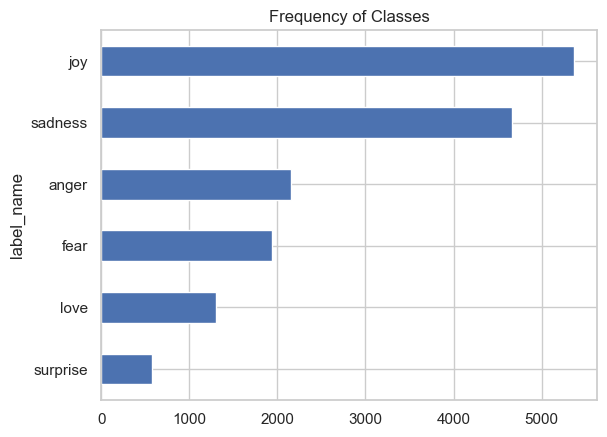

In [29]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.show()
     

<Axes: title={'center': 'Words Per Tweet'}, xlabel='label_name'>

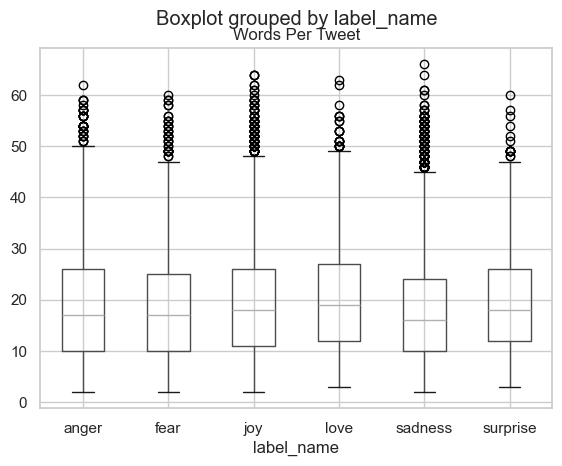

In [30]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet", by='label_name')

In [31]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

c:\Users\AJDAR\Desktop\dat_science_sources\pytorch_deep_learning_book\myenv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\AJDAR\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [32]:

text = "I love Machine Learning!. Tokenization is awesome"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 1012, 19204, 3989, 2003, 12476, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [33]:

tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'love', 'machine', 'learning', '!', '.', 'token', '##ization', 'is', 'awesome', '[SEP]']


In [34]:

emotion.reset_format()

In [36]:

def tokenize(batch):
  temp =tokenizer(batch['text'], padding=True, truncation=True)
  return temp

In [37]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)
emotions_encoded

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 20484.20 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [38]:

inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  1045,  2293,  3698,  4083,   999,  1012, 19204,  3989,  2003,
         12476,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [39]:

model = AutoModel.from_pretrained(model_ckpt)

In [40]:
with torch.no_grad():
  outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
     

last_hidden_states.shape

torch.Size([1, 12, 768])

In [41]:
num_labels = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)
     

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
batch_size = 64
model_name = "distilbert-finetuned-emotion"

training_args = TrainingArguments(output_dir = model_name,
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                  weight_decay=0.01,
                                  eval_strategy = 'epoch',
                                  disable_tqdm=False)

In [44]:

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}


In [45]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

C:\Users\AJDAR\AppData\Local\Temp\ipykernel_9192\3396887920.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [46]:

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.288620,0.917000,0.916387
2,0.508000,0.205869,0.928500,0.928746


TrainOutput(global_step=500, training_loss=0.508009765625, metrics={'train_runtime': 114.4664, 'train_samples_per_second': 279.558, 'train_steps_per_second': 4.368, 'total_flos': 720342861696000.0, 'train_loss': 0.508009765625, 'epoch': 2.0})

In [47]:

preds_outputs = trainer.predict(emotions_encoded['test'])
preds_outputs.metrics
     

{'test_loss': 0.2066231369972229,
 'test_accuracy': 0.9205,
 'test_f1': 0.9200637892187801,
 'test_runtime': 3.5837,
 'test_samples_per_second': 558.083,
 'test_steps_per_second': 8.929}

In [48]:
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = emotions_encoded['test'][:]['label']

In [49]:
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true, y_preds))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       581
           1       0.94      0.94      0.94       695
           2       0.78      0.84      0.81       159
           3       0.92      0.95      0.93       275
           4       0.88      0.89      0.89       224
           5       0.80      0.62      0.70        66

    accuracy                           0.92      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [50]:

label_counts

label_name
surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: count, dtype: int64

In [ ]:

text = 'i want to kiss you'
input_encoded = tokenizer(text, return_tensors='pt').to(device)
model = model.to(device)
with torch.no_grad():
  outputs = model(**input_encoded)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()
pred, classes[pred]

(2, 'love')

: 

In [52]:

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.5488, -0.4635, -0.4557,  1.8869, -0.3569, -2.2157]],
       device='cuda:0'), hidden_states=None, attentions=None)